# JOSS 2025 

## Setup

In [1]:
import qmcpy as qp 
import numpy as np
import os

In [27]:
import matplotlib 
matplotlib.rcParams['figure.dpi'] = 256
from matplotlib import pyplot 
import tueplots 
import seaborn as sns
from tueplots import bundles,figsizes
pyplot.rcParams.update(bundles.icml2024())
COLORS = ['xkcd:purple', 'xkcd:green', 'xkcd:blue', 'xkcd:orange']
MARKERS = ["*","^","o","s"]
MARKERSIZE = 5
OUTDIR = "JOSS2025.outputs"
FIGWIDTH = 500/72
assert os.path.isdir(OUTDIR)

## Listings

In [ ]:
import qmcpy as qp 
qp.__version__

'1.6.3b'

In [ ]:
dnb2 = qp.DigitalNetB2(dimension=2)
x = dnb2(2**7)
print(x.shape)


(128, 2)


In [ ]:
dnb2 = qp.DigitalNetB2(dimension=2,replications=5)
x = dnb2(2**7)
print(x.shape)

(5, 128, 2)


In [ ]:
dnb2 = qp.DigitalNetB2( # special case of a digital net
    dimension = 12, # monthly monitoring 
    seed = 7, # for reproducibility
)
asian_option = qp.FinancialOption(
    sampler = dnb2 ,
    option = "ASIAN",
    call_put = "CALL",
    asian_mean_type = "GEOMETRIC",
    asian_mean_quadrature_rule = "RIGHT", 
    volatility = 0.5, 
    start_price = 30., 
    strike_price = 35., 
    interest_rate = 0.01, # 1% interest rate
    t_final = 1, # 1 year 
)
qmc_algorithm = qp.CubQMCNetG(
    integrand = asian_option,
    abs_tol = 1e-3,
    rel_tol = 0,
    n_init = 2**8,
)
approx_value,data = qmc_algorithm.integrate()
print(approx_value)
print(data)

1.766681879731952
AccumulateData (AccumulateData)
    solution        1.767
    comb_bound_low  1.766
    comb_bound_high 1.768
    comb_bound_diff 0.002
    comb_flags      1
    n_total         2^(15)
    n               2^(15)
    time_integrate  0.079
CubQMCNetG (AbstractStoppingCriterion)
    abs_tol         0.001
    rel_tol         0
    n_init          2^(8)
    n_limit         2^(35)
FinancialOption (AbstractIntegrand)
    option          ASIAN
    call_put        CALL
    volatility      2^(-1)
    start_price     30
    strike_price    35
    interest_rate   0.010
    t_final         1
    asian_mean_type GEOMETRIC
BrownianMotion (AbstractTrueMeasure)
    time_vec        [0.083 0.167 0.25  ... 0.833 0.917 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.083 0.083 0.083 ... 0.083 0.083 0.083]
                     [0.083 0.167 0.167 ... 0.167 0.167 0.167]
                     [0.083 0.167 0.25  ... 0.25  0.25  0.25 ]
            

In [ ]:
import numpy as np
import scipy.stats
def borehole(t): # t.shape == (..., n, d) for n samples in d dimensions
    """ https://www.sfu.ca/~ssurjano/borehole.html """
    rw, r, Tu, Hu, Tl, Hl, L, Kw = np.moveaxis(t, -1, 0)
    numer = 2 * np.pi * Tu * (Hu-Hl) / np.log(r / rw)
    denom =  1 + 2 * L * Tu / (np.log(r / rw) * rw**2 * Kw) + Tu / Tl
    y = numer / denom
    return y
indep_distribs = [
    scipy.stats.norm(loc=0.10, scale=0.0161812),
    scipy.stats.lognorm(scale=np.exp(7.71), s=1.0056),
    scipy.stats.uniform(loc=63070, scale=115600-63070),
    scipy.stats.uniform(loc=990, scale=1110-990),
    scipy.stats.uniform(loc=63.1, scale=116-63.1),
    scipy.stats.uniform(loc=700, scale=820-700),
    scipy.stats.uniform(loc=1120, scale=1680-1120),
    scipy.stats.uniform(loc=9855, scale=12045-9855),
]
discrete_distrib = qp.Lattice(dimension = 8, seed = 11)
true_measure = qp.SciPyWrapper(discrete_distrib, indep_distribs)
integrand = qp.CustomFun(true_measure, borehole)
qmc_algorithm = qp.CubQMCBayesLatticeG(
    integrand = integrand,
    ptransform = "BAKER", # periodization transform 
    abs_tol = 1e-3,
    rel_tol = 1e-5,
    error_fun = "BOTH" # abs and rel tol satisfied, default is "EITHER",
)
approx_value,data = qmc_algorithm.integrate()
print(approx_value)
print(data)

73.73882925995092
AccumulateData (AccumulateData)
    solution        73.739
    comb_bound_low  73.739
    comb_bound_high 73.739
    comb_bound_diff 2.76e-04
    comb_flags      1
    n_total         2^(16)
    n               2^(16)
    time_integrate  0.897
CubQMCBayesLatticeG (AbstractStoppingCriterion)
    abs_tol         0.001
    rel_tol         1.00e-05
    n_init          2^(8)
    n_limit         2^(22)
    order           2^(1)
CustomFun (AbstractIntegrand)
SciPyWrapper (AbstractTrueMeasure)
Lattice (AbstractLDDiscreteDistribution)
    d               2^(3)
    replications    1
    randomize       SHIFT
    gen_vec_source  kuo.lattice-33002-1024-1048576.9125.txt
    order           NATURAL
    n_limit         2^(20)
    entropy         11


## Points

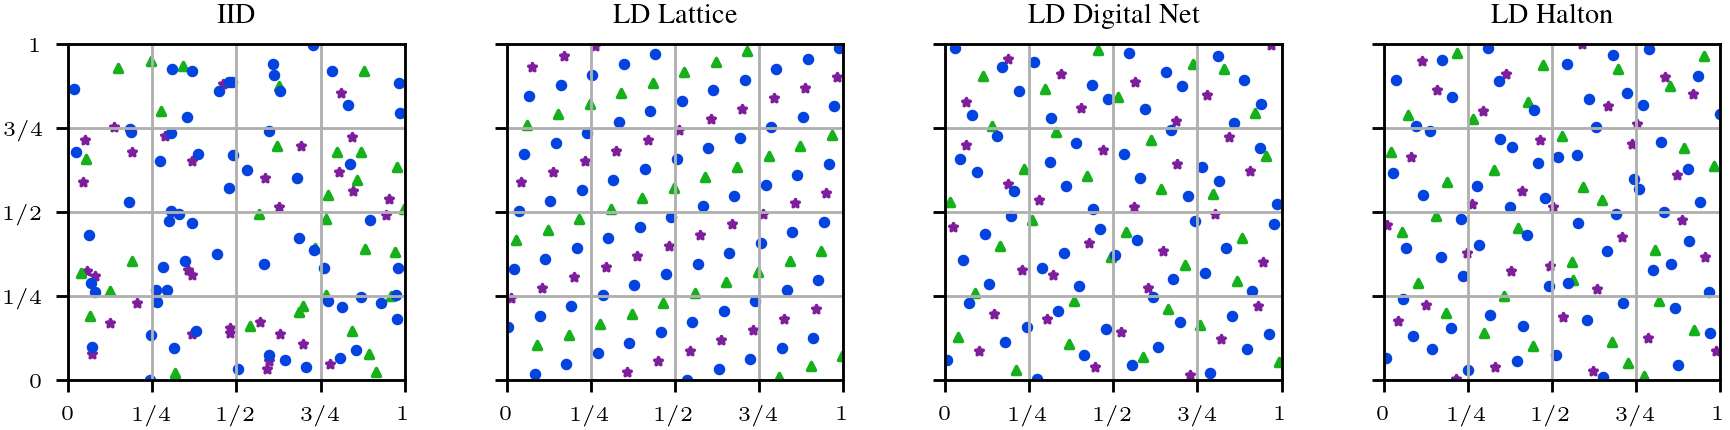

In [28]:
ns = np.array([0,2**5,2**6,2**7])
assert len(COLORS)>=(len(ns)-1) and len(MARKERS)>=(len(ns)-1)

nmax = ns.max() 

data = [
    ("IID",qp.IIDStdUniform(2,seed=7)(nmax)),
    ("LD Lattice",qp.Lattice(2,seed=7)(nmax)),
    ("LD Digital Net",qp.DigitalNetB2(2,seed=7)(nmax)),
    ("LD Halton",qp.Halton(2,seed=7)(nmax)),
]

nrows = 1
ncols = len(data)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,sharey=True,sharex=True,figsize=(FIGWIDTH,FIGWIDTH/ncols))
for i,(name,x) in enumerate(data):
    for j in range(len(ns)-1):
        nmin = ns[j]
        nmax = ns[j+1]
        ax[i].scatter(x[nmin:nmax,0],x[nmin:nmax,1],marker=MARKERS[j],color=COLORS[j],s=MARKERSIZE)
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1/4,1/2,3/4,1]); ax[i].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    ax[i].set_yticks([0,1/4,1/2,3/4,1]); ax[i].set_yticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    ax[i].grid()
    ax[i].set_aspect(1) 
    ax[i].set_title(name)
fig.savefig(OUTDIR+"/points.pdf")

## Convergence

In [29]:
tag = "FULL"
force = False
datapath = "%s/%s.npy"%(OUTDIR,tag)
if (not os.path.isfile(datapath)) or force:
    d = 12
    n_init = 2**8
    eps = 10**np.linspace(np.log10(5e-1),np.log10(1e-4),10)
    trials = 100
    with np.printoptions(formatter={"float":lambda x: "%.1e"%x}): print("eps = %s"%str(eps))
    problem = lambda discrete_distrib: \
        qp.FinancialOption(discrete_distrib,
            option = "ASIAN",
            call_put = "CALL",
            asian_mean_type = "GEOMETRIC",
            asian_mean_quadrature_rule = "RIGHT", 
            volatility = 0.5, 
            start_price = 30., 
            strike_price = 35., 
            interest_rate = 0.01,
            t_final = 1)
    exact_value = problem(qp.IIDStdUniform(d)).get_exact_value()
    print("exact value = %.3f\n"%exact_value)
    algorithms = {
        "IID MC": [1e-2, lambda atol: qp.CubMCG(problem(qp.IIDStdUniform(d)),abs_tol=atol,rel_tol=0,n_init=n_init)], 
        "QMC Digital Net'": [0, lambda atol: qp.CubQMCNetG(problem(qp.DigitalNetB2(d)),abs_tol=atol,rel_tol=0,n_init=n_init)],
        "QMC Lattice": [0, lambda atol: qp.CubQMCLatticeG(problem(qp.Lattice(d)),abs_tol=atol,rel_tol=0,n_init=n_init)],
    }
    keys = list(algorithms.keys())
    n_totals = {}
    times = {}
    approxs = {}
    for key,(eps_threshold,sc_constsruct) in algorithms.items():
        print(key)
        n_totals[key] = np.nan*np.ones((len(eps),trials))
        times[key] = np.nan*np.ones((len(eps),trials))
        approxs[key] = np.nan*np.ones((len(eps),trials))
        for j in range(len(eps)):
            if eps[j]<eps_threshold: break
            print("\teps[j] = %.1e"%eps[j])
            for t in range(trials):
                sc = sc_constsruct(eps[j])
                sol,data = sc.integrate()
                approxs[key][j,t] = sol
                n_totals[key][j,t] = data.n_total 
                times[key][j,t] = data.time_integrate
    _data = {
        "eps": eps,
        "n_totals": n_totals,
        "times": times, 
        "approxs": approxs,
        "keys": keys, 
        "exact_value": exact_value,
    }
    np.save(datapath,_data)
else:
    _data = np.load(datapath,allow_pickle=True).item()
    eps = _data["eps"]
    n_totals = _data["n_totals"]
    times = _data["times"]
    approxs = _data["approxs"]
    keys = _data["keys"]
    exact_value = _data["exact_value"]

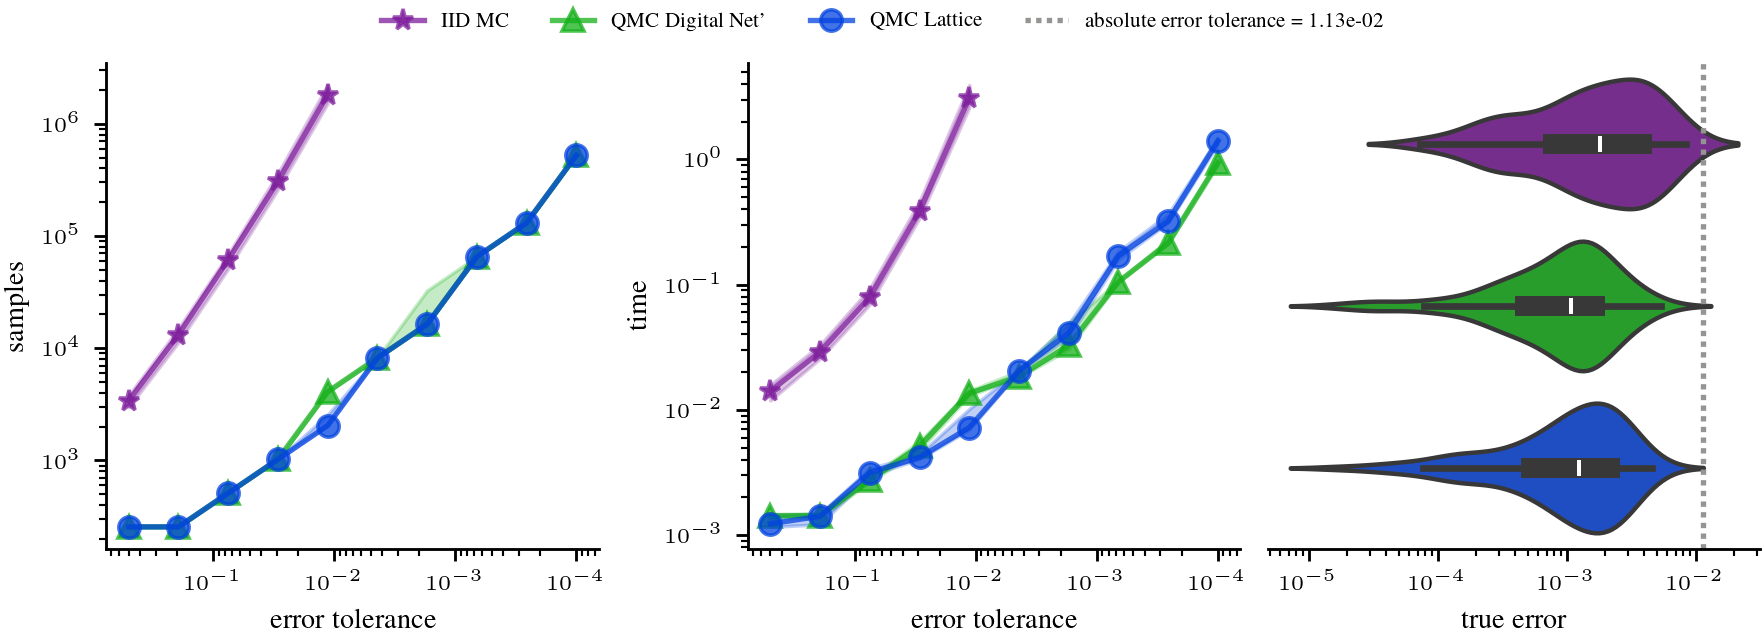

In [30]:
nrows = 1
ncols = 3
alpha = .25
alpha2 = .75
qlow = .25
qhigh = .75
jstar = 4
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(FIGWIDTH,FIGWIDTH/ncols),sharey=False,sharex=False)
for i,key in enumerate(keys):
    n_total = n_totals[key] 
    time = times[key]
    approx = approxs[key]
    color = COLORS[i]
    ax[0].plot(eps,np.quantile(n_total,.5,axis=1),label=key,color=color,marker=MARKERS[i],alpha=alpha2)
    ax[0].fill_between(eps,np.quantile(n_total,qlow,axis=1),np.quantile(n_total,qhigh,axis=1),color=color,alpha=alpha)
    ax[1].plot(eps,np.quantile(time[:,:],.5,axis=1),color=color,marker=MARKERS[i],alpha=alpha2)
    ax[1].fill_between(eps,np.quantile(time,qlow,axis=1),np.quantile(time,qhigh,axis=1),color=color,alpha=alpha)
errors = np.stack([np.abs(exact_value-approxs[key][jstar]) for key in keys],axis=1)
sns.violinplot(data=errors,ax=ax[2],log_scale=True,orient="h",palette=COLORS[:len(keys)],inner="box")
for i in range(2):
    ax[i].set_xscale("log",base=10) 
    ax[i].set_yscale("log",base=10)
    ax[i].set_xlabel("error tolerance")
    ax[i].xaxis.set_inverted(True)
for i in range(3):
    for spine in ["top","right"]: ax[i].spines[spine].set_visible(False)
ax[2].axvline(eps[jstar],color="xkcd:gray",linestyle=(0,(1,1)),label="absolute error tolerance = %.2e"%eps[jstar])
ax[0].set_ylabel("samples")
ax[1].set_ylabel("time")
ax[2].set_xlabel("true error")
ax[2].get_yaxis().set_visible(False)
ax[2].spines["left"].set_visible(False)
fig.legend(frameon=False,loc="upper center",ncols=4,bbox_to_anchor=(.5,1.1))
fig.savefig(OUTDIR+"/stopping_crit.pdf")